In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [236]:
# CONFIG
CYCLES = 15

N_BUYERS = 50
N_SELLERS = 50

DAYS = 100
SEATS = 100
TICKET_UTILITY = 1
TICKET_COST = 1

In [211]:
# SELLERS MATRIX
# columns: c, d, e, seats_left, profits
def init_sellers():
    sellers = np.zeros((N_SELLERS, 5))
    # c 
    sellers[:, 0] = 0.1 * np.random.randn(N_SELLERS)
    # d
    sellers[:, 1] = 0.1 * np.random.randn(N_SELLERS)
    # e
    sellers[:, 2] = 1 * np.random.randn(N_SELLERS)
    # seats_left
    sellers[:, 3] = np.random.poisson(SEATS, size=N_SELLERS)
    # intial profits negative -- each ticket leads to cost 1
    sellers[:, 4] = -sellers[:, 3]
    return sellers

# seller model
# price = c * days_left + d * seats_left + e  [NOT for now: + * days_left * seats_left]
def get_price(seller, days_left):
    price = seller[0] * days_left + seller[1] * seller[3] + seller[2]
    return np.maximum(price, 0)

# seller evolution
# evolve sellers with highest profits
def resample_sellers(sellers):
    scores = sellers[:, 4] - np.min(sellers[:, 4])
    p_replicate = scores/(np.sum(scores))
    
    indices_drawn = np.random.choice(np.arange(len(p_replicate)), size=len(p_replicate), p=p_replicate)
    sellers = sellers[indices_drawn, :]

    return sellers
    
def add_seller_noise(sellers):
    # c 
    sellers[:, 0] += 0.05 * np.random.randn(sellers.shape[0])
    # d
    sellers[:, 1] += 0.05 * np.random.randn(sellers.shape[0])
    # e
    sellers[:, 2] += 0.5 * np.random.randn(sellers.shape[0])
    
    return sellers


In [237]:
# BUYERS MATRIX
# columns: a, b, b2, tickets_bought, money_spent
def init_buyers():
    buyers = np.zeros((N_BUYERS, 6))
    # a 
    buyers[:, 0] = 1 * np.random.randn(N_BUYERS)
    # b
    buyers[:, 1] = 1 * np.random.randn(N_BUYERS)
    # b2
    buyers[:, 2] = 0.01 * np.random.randn(N_BUYERS)
    
    return buyers
    
# buyer model
# P(buy) = sigmoid(a * price + b + b2 * days_left)

def get_p_buy(buyers, price, days_left, seats_left):
#     p = sigmoid(buyers[:, 0] * price + buyers[:, 1] + buyers[:, 2] * days_left)
    p = np.clip((buyers[:, 0] * price + buyers[:, 1] + buyers[:, 2] * days_left), 0, 1)
    return p

def buy_tickets(buyers, seats_left, price, days_left):
    if seats_left <= 0:
        return 0, buyers
    
    p = get_p_buy(buyers, price, days_left, seats_left)
    roll = np.random.rand(len(p))
    
    orders = roll < p
    seats_sold = np.count_nonzero(orders)
    if seats_sold <= seats_left:
        lucky = orders
    else: # if not enough seats
        indices = np.arange(len(p))[orders]
        lucky = np.random.choice(indices, seats_left, replace=False)

    # add ticket
    buyers[lucky, 3] += 1
    # inc money spent
    buyers[lucky, 4] += price
    
    # discounting future money 
#     buyers[lucky, 4] += price / 2.25**((DAYS - days_left)/365)
    
    return min(seats_sold, seats_left), buyers

# buyer evolution
# evolve buyers that get the highest utility
# utility = 100 * tickets_bought - money_spent

def resample_buyers(buyers):
    utilities = TICKET_UTILITY * buyers[:, 3] - buyers[:, 4]
    utilities_shift = utilities - np.min(utilities)
    p_replicate = utilities_shift**2/np.sum(utilities_shift**2)
    
    indices_drawn = np.random.choice(np.arange(len(p_replicate)), size=len(p_replicate), p=p_replicate)
    buyers = buyers[indices_drawn, :]
    
    return buyers
    
def add_buyer_noise(buyers):
    # add noise
    # a
    buyers[:, 0] += 0.25 * np.random.randn(buyers.shape[0])
    # b
    buyers[:, 1] += 0.25 * np.random.randn(buyers.shape[0])
    
    buyers[:, 2] += 0.05 * np.random.randn(buyers.shape[0])
    

    return buyers

In [238]:
sellers = init_sellers()
buyers = init_buyers()

price_record = np.zeros((CYCLES, N_SELLERS, DAYS))
seats_record = np.zeros((CYCLES, N_SELLERS, DAYS))

/home/ira/code/envs/flexi/lib/python3.5/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


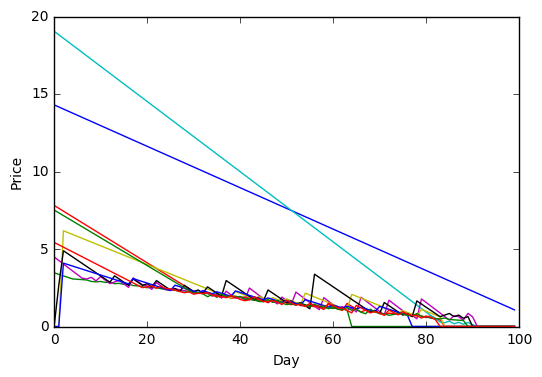

In [244]:

for cycle in range(CYCLES):
    # reset counters
    buyers[:, 3] = 0
    buyers[:, 4] = 0
    sellers[:, 3] = np.random.poisson(SEATS, size=N_SELLERS)
    sellers[:, 4] = -sellers[:, 3]

    buyers = add_buyer_noise(buyers)
    for seller_idx in range(N_SELLERS):
        for day in range(DAYS):
            seats_left = sellers[seller_idx, 3]
            seats_record[cycle, seller_idx, day] = seats_left
            days_left = DAYS - day
            
            if seats_left <= 0:
                price = 0
            else:
                price = get_price(sellers[seller_idx, :], days_left)
            
            price_record[cycle, seller_idx, day] = price
            seats_sold, buyers = buy_tickets(buyers, seats_left, price, days_left)
            sellers[seller_idx, 3] -= seats_sold
            sellers[seller_idx, 4] += seats_sold * price
        
    buyers = resample_buyers(buyers)
    
    # zero counters
    buyers[:, 3] = 0
    buyers[:, 4] = 0
    sellers[:, 3] = np.random.poisson(SEATS, size=N_SELLERS)
    sellers[:, 4] = -sellers[:, 3]
    
    sellers = add_seller_noise(sellers)
    for seller_idx in range(N_SELLERS):
        for day in range(DAYS):
            seats_left = sellers[seller_idx, 3]
            seats_record[cycle, seller_idx, day] = seats_left
            days_left = DAYS - day
            
            if seats_left <= 0:
                price = 0
            else:
                price = get_price(sellers[seller_idx, :], days_left)
            
            price_record[cycle, seller_idx, day] = price
            seats_sold, buyers = buy_tickets(buyers, seats_left, price, days_left)
            sellers[seller_idx, 3] -= seats_sold
            sellers[seller_idx, 4] += seats_sold * price
            
#     sellers = resample_sellers(sellers)
    buyers = resample_buyers(buyers)
    
        # zero counters
    buyers[:, 3] = 0
    buyers[:, 4] = 0
    sellers[:, 3] = np.random.poisson(SEATS, size=N_SELLERS)
    sellers[:, 4] = -sellers[:, 3]
    
    for seller_idx in range(N_SELLERS):
        for day in range(DAYS):
            seats_left = sellers[seller_idx, 3]
            seats_record[cycle, seller_idx, day] = seats_left
            days_left = DAYS - day
            
            if seats_left <= 0:
                price = 0
            else:
                price = get_price(sellers[seller_idx, :], days_left)
            
            price_record[cycle, seller_idx, day] = price
            seats_sold, buyers = buy_tickets(buyers, seats_left, price, days_left)
            sellers[seller_idx, 3] -= seats_sold
            sellers[seller_idx, 4] += seats_sold * price
            
    sellers = resample_sellers(sellers)
    buyers = resample_buyers(buyers)
            
    
plt.plot(range(DAYS), price_record[0,0:10,:].T)
plt.ylabel('Price')
plt.xlabel('Day')   

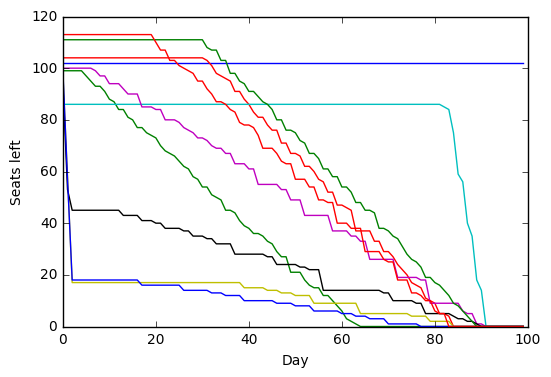

In [245]:
plt.plot(range(DAYS), seats_record[0,0:10,:].T)
plt.ylabel('Seats left')
plt.xlabel('Day')

In [249]:
sellers[:, 4]

array([   5.29585332,   84.90955441,   48.12416644,   95.53234922,
        116.1187301 ,   95.53234922,   95.53234922,   48.4644987 ,
         90.03634832,  118.77105856,   90.03634832,   57.0278423 ,
         26.09751125,   76.62438692,   13.71430166,    5.45036215,
        -63.40326322,   43.14837438,   54.12491377,   96.7404254 ,
         -9.92027031,  -62.73904046,  -21.89470215,   84.90955441,
          5.89736441,   13.71430166,   54.12491377,   48.4644987 ,
        111.55171157,   -6.1256152 ,   26.09751125,  116.1187301 ,
        -54.82378881,   -6.1256152 ,   26.09751125,   90.03634832,
         48.4644987 ,  -61.48989303,   13.71430166,  -54.82378881,
        118.77105856,   24.09988106,   86.26896502,  105.99631731,
         54.12491377,   43.14837438,   83.93250701,   30.87354837,
        -61.48989303,   26.09751125])

In [250]:
buyers[:, 3].astype('int') - buyers[:, 4].astype('int')

array([  13,   58,    0,   29,   19,   28,   58,   29,   49,   28,   22,
         49,   33,   13,   27,   33,   21,   16,   31,   31,   31, -177,
         29,   21,   32,   30,   32,    0,   31,   27,   28, -160,    1,
         32,    0,   21,   31,   28,   33,   31,   22,   32,   29,   13,
         28,   25, -177,   29,   30,   13])

In [251]:
buyers[:,2]

array([ 0.08988248,  0.09598964, -0.07348249,  0.04631138,  0.00744616,
        0.06312616,  0.09598964, -0.020879  ,  0.09598964,  0.07207222,
        0.09778075,  0.09598964,  0.04108163,  0.08988248,  0.08236615,
        0.04108163, -0.020879  ,  0.09643653,  0.06312616,  0.04212932,
        0.06312616,  0.12607468,  0.05537303,  0.09778075, -0.020879  ,
        0.06312616, -0.020879  , -0.00326955,  0.04212932,  0.08236615,
        0.06312616,  0.12607468, -0.01597409, -0.020879  , -0.00326955,
       -0.020879  ,  0.06312616,  0.06312616,  0.04108163,  0.07701042,
       -0.020879  , -0.020879  ,  0.06312616,  0.08988248,  0.07207222,
        0.07056677,  0.12607468, -0.020879  ,  0.06312616,  0.08988248])